In [33]:
using NGSIM
using AutomotiveDrivingModels
using AutoViz
using Interact # Make video in notebook
using Reel # Save video as gif
using CSV # For writing to csv
using DataFrames # For writing to csv
using PyPlot # For in notebook plotting
using Distributions
using Test

## Video making using recorded cars on ngsim
- Trajdatas is what the car trajectories are stored in
- We want to color the ego vehicle differently to be able to see it

In [37]:
td1 = load_trajdata(1)

scene = Scene(500)
temp_scene = get!(scene,td1,1000)
dummy = render(temp_scene,ROADWAY_101);
typeof(dummy)

Cairo.CairoSurfaceBase{UInt32}

In [40]:
# Setting up for video saving using Reel
frames = Frames(MIME("image/png"), fps=10)
for i in 400:500
    temp_scene = get!(scene,td1,i)
    carcolors = Dict{Int,Colorant}()
    for veh in temp_scene
        #@show veh.id
        #carcolors[veh.id] = in(veh.id, egoid) ? colorant"blue" : colorant"green"
        
            # Color cars green when they are in segment 3
        if veh.state.posF.roadind.tag.segment == 3
            carcolors[veh.id] = colorant"green"
        end
        
    end
    overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
    scene_visual = render(temp_scene, ROADWAY_101, 
        #cam=CarFollowCamera{Int}(2,5.0),
        cam=StaticCamera(VecE2(1966400, 570900), 5.0),
        #cam=FitToContentCamera(0.),
        overlays,
        car_colors=carcolors)
    push!(frames,scene_visual)
end
write("ngsim_segment_zoomed.mp4",frames)

"ngsim_segment_zoomed.mp4"

In [ ]:
# argument 1 loads i101 7:50 to 8:05.
# load_trajdata function defined in NGSIM.jl/src/trajdata.jl
td1 = load_trajdata(1); 

scene = Scene(500)
egoid = [25,5,8,9,10,12,21] # These vehicle ids will be colored blue if the egoid test is performed

# List of the vehicle ids in the scene
# veh.id = 2 5 8 9 10 12 13 14 18 20 21 22 23 25 26 27 31 32 34 35 39 48

# Drive here in the notebook. Replay the trajectory as recorded in the ngsim data
@manipulate for i in 400:500
    temp_scene = get!(scene,td1,i)
    
    carcolors = Dict{Int,Colorant}()
    for veh in temp_scene
        #@show veh.id
        #carcolors[veh.id] = in(veh.id, egoid) ? colorant"blue" : colorant"green"
        
            # Color cars green when they are in segment 3
        if veh.state.posF.roadind.tag.segment == 3
            carcolors[veh.id] = colorant"green"
        end
        
    end
    overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
    render(temp_scene, ROADWAY_101, 
        #cam=CarFollowCamera{Int}(2,5.0),
        #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
         cam=FitToContentCamera(0.),
        overlays,
        car_colors=carcolors)
end

In [ ]:
for i in 150:160
    scene = Scene(500) # Have to create a new scene container every time, wonder how manipulate got by without
    t = get!(scene,td1,i)
    for veh in t
        if veh.state.posF.roadind.tag.segment == 3
            print("$(veh.id) is in segment 3\n")
        else
            print("$(veh.id) not in segment 3\n")
        #display(t.entities[1].state.posF.roadind.tag.segment)
        end
    end
end

# Hallucination from prerecorded scene

In [ ]:
# Let's take a scene from prerecorded trajdata and try a hallucination from that
scene_input = Scene(500)
get!(scene_input,td1,300)
scene = deepcopy(scene_input)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene];
#render(start_scene, ROADWAY_101, cam=StaticCamera(VecE2(1966400, 570900), 5.0),overlays)

In [ ]:
scene.entities[2].state.posF.s

In [ ]:
n_cars = scene.n
models = Dict{Int,DriverModel}()
for veh in scene
    models[veh.id] = IntelligentDriverModel(v_des=10.0)
end

In [ ]:
n_steps = 1
dt = 0.1
rec = SceneRecord(n_steps,dt)
simulate!(rec,scene,roadway,models,n_steps)

In [ ]:
scene.entities[2].state.posF.s

In [ ]:
rec.frames[1].entities[2].state.posF.s

In [ ]:
# Render the frame after doing the simulation for 1 step
carcolors = Dict{Int,Colorant}()
carcolors[2] = colorant"green"
render(rec.frames[1],roadway,cam=CarFollowCamera{Int}(2,5.0),car_colors=carcolors)

In [23]:
"""
# Example
td1 = load_trajdata(1);
scene = Scene(500)
get!(scene,td1,300)
display(scene.entities[2].state.posF.s)
roadway = ROADWAY_101;
particle = Dict(:v_des=>25.0,:σ=>0.5)
hallucinate_a_step(roadway,scene,particle,car_id=scene.entities[2].id)
"""
function hallucinate_a_step(roadway,scene_input,particle;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    
    scene = deepcopy(scene_input)
    #scene = scene_input # This was the failure case
    n_cars = scene.n 

    models = Dict{Int, DriverModel}()
    
    # Create driver models for all the cars in the scene
    for veh in scene
        if veh.id == car_id
            models[veh.id] = IntelligentDriverModel(;particle...)
        else
            # TODO: RESEARCH QUESTION: What drives the other vehicles in the hallucination
            models[veh.id] = IntelligentDriverModel(v_des=10.0)
        end
    end
    
    n_steps = 1
    dt = 0.1
    rec = SceneRecord(n_steps, dt)
    
    simulate!(rec, scene, roadway, models, n_steps)
    
    X = Array{Float64}(undef,n_steps, 1)

    for t in 1:n_steps
        f = rec.frames[n_steps - t + 1]
        
            # Access the vehicle with id as car_id and return its frenet s
        X[t,1] = scene.entities[findfirst(car_id,f)].state.posF.s

            # The above one liner in for loop fashion
#         for veh in f
#             if veh.id == car_id
#                 s = veh.state.posF
#                 X[t, 1] = s.s #position
#                 break
#             end
#         end
    end
    return X[1]
end

hallucinate_a_step (generic function with 1 method)

In [25]:
td1 = load_trajdata(1);
scene = Scene(500)
get!(scene,td1,300)
display(scene.entities[1].state.posF.s)
roadway = ROADWAY_101;
particle = Dict(:v_des=>25.0,:σ=>0.5)
hallucinate_a_step(roadway,scene,particle,car_id=scene.entities[1].id)

247.9166753982852

-0.9120744469647664

In [26]:
function to_matrix_form(p_set_dict)
    # Get the number of particles
    # Extract keys (i.e. params) and corresponding array of values
    num_p = -100
    num_params = length(keys(p_set_dict))
    
    params = Array{Symbol}(undef,num_params,1)
    vec_val_vec = Array{Array}(undef,num_params,1) #Array containing associated values for each key
    for (kk,kv) in enumerate(p_set_dict)
        num_p = length(kv[2])
        params[kk] = kv[1]
        vec_val_vec[kk] = kv[2]
    end
    
    # Create a matrix with different rows being different parameters and diff cols being diff particles
    p_mat = hcat(vec_val_vec...)'
    
    return p_mat, params, vec_val_vec
end

to_matrix_form (generic function with 1 method)

In [30]:
function compute_particle_likelihoods(roadway,f,trupos,p_set_dict;car_id=-1)
    if car_id==-1 @show "Please give valid car_id" end
    timestep = 0.1 #TODO: Remove hardcoding
    p_mat, params, vec_val_vec = to_matrix_form(p_set_dict)
    
    num_params=size(p_mat)[1]
    num_p = size(p_mat)[2]
    lkhd_vec = Array{Float64}(undef,num_p)
    for i in 1:num_p    
        # Create dict version for a single particle
        p_dict = Dict()
        for j in 1:num_params
            p_dict[params[j]]=vec_val_vec[j][i]
        end
        
        std_dev_acc = p_dict[:σ]
        
        # hack to avoid the std_dev_pos become negative and error Normal distb
        if std_dev_acc <= 0 std_dev_acc = 0.1 end
        
        # TODO: This math needs to be verified from random variable calculations
        std_dev_pos = timestep*timestep*std_dev_acc
            
        hpos = hallucinate_a_step(roadway,f,p_dict,car_id=car_id)
        lkhd_vec[i] = pdf(Normal(hpos,std_dev_pos),trupos[1])
    end
    return lkhd_vec,p_mat,params
end

compute_particle_likelihoods (generic function with 1 method)

In [32]:
v_array = [10.,15.,20.,25.,30.]
num_p = length(v_array)
sig_array = [0.1,0.1,0.1,0.1,0.1]	
p_set_dict = Dict(:v_des=>v_array,:σ=>sig_array)
td1 = load_trajdata(1);
scene = Scene(500)
get!(scene,td1,300)
roadway = ROADWAY_101;
trupos = hallucinate_a_step(roadway,scene,Dict(:v_des=>25.0,:σ=>0.0),car_id=4)
lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,scene,trupos,p_set_dict,car_id=4)

([7.81862e-206, 0.000393595, 367.381, 398.014, 398.716], [10.0 15.0 … 25.0 30.0; 0.1 0.1 … 0.1 0.1], Symbol[:v_des; :σ])

In [34]:
	@test length(lkhd_vec) == num_p
	@test length(params) == 2
	@test size(p_mat)[1] == 2
	@test size(p_mat)[2] == 5
	@test any(isnan,lkhd_vec) == false

Test Passed

In [35]:
function update_p_one_step(roadway,f,trupos,p_set_dict;
                            car_id=-1,approach="pf",elite_fraction_percent=20)
    if car_id==-1 @show "Provide valid car_id" end
    
    lkhd_vec,p_mat,params = compute_particle_likelihoods(roadway,f,trupos,p_set_dict,car_id=car_id)
    
    num_params = size(p_mat)[1]
    num_p = size(p_mat)[2]
    
    if approach=="pf"
        p_weight_vec = weights(lkhd_vec./sum(lkhd_vec)) # Convert to weights form to use julia sampling
        idx = sample(1:num_p,p_weight_vec,num_p)
        new_p_mat = p_mat[:,idx] #Careful that idx is (size,1) and not (size,2)
    end
    
    if approach=="cem"
        sortedidx = sortperm(lkhd_vec,rev=true)
        numtop = convert(Int64,ceil(num_p*elite_fraction_percent/100.0))
        best_particles = p_mat[:,sortedidx[1:numtop]] # elite selection
#         @show best_particles
        p_distribution = fit(MvNormal,best_particles) # fit distb using elites
        new_p_mat = rand(p_distribution,num_p) # sample num_p new particles from dist
    end
    
    new_p_set_dict = to_dict_form(params,new_p_mat)
    return new_p_set_dict
end

update_p_one_step (generic function with 1 method)

# HighD experimentation

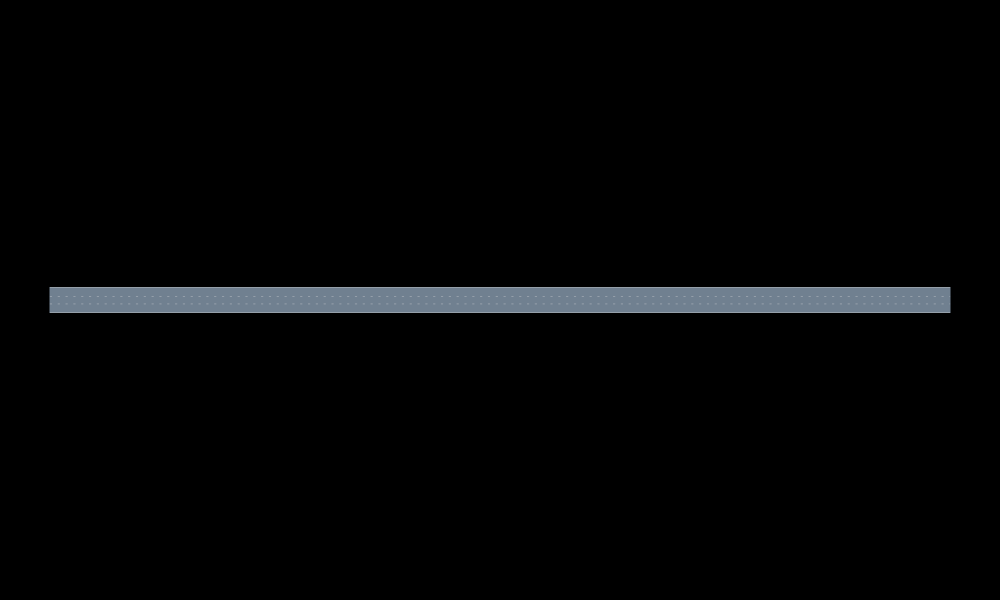

In [41]:
render(open(io->read(io, MIME"text/plain"(), Roadway), "ngsim_11_lower.txt", "r"))

In [42]:
highd = open(io->read(io, MIME"text/plain"(), Trajdata), 
    "trajdata_Data11_Road1_nLIOD3_lower.txt", "r");

In [50]:
length(highd.frames) # highd is of type listrecord

15277

In [44]:
roadway_highd = open(io->read(io, MIME"text/plain"(), Roadway), 
    "ngsim_11_lower.txt", "r")
frames = Frames(MIME("image/png"), fps=10)
for i in 1000:1000
    temp_scene = get!(scene,highd,i)
    carcolors = Dict{Int,Colorant}()
    for veh in temp_scene
        #@show veh.id
        #carcolors[veh.id] = in(veh.id, egoid) ? colorant"blue" : colorant"green"
        
            # Color cars green when they are in segment 3
        if veh.state.posF.roadind.tag.segment == 3
            carcolors[veh.id] = colorant"green"
        end
        
    end
    overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, 
                pos=VecSE2(veh.state.posG.x+0.5,veh.state.posG.y+0.5)) for veh in scene]
    scene_visual = render(temp_scene, roadway_highd, 
        #cam=CarFollowCamera{Int}(2,5.0),
        #cam=StaticCamera(VecE2(1966400, 570900), 5.0),
        cam=FitToContentCamera(0.),
        overlays,
        car_colors=carcolors)
    push!(frames,scene_visual)
end
write("media/highd.mp4",frames)

"media/highd.mp4"